In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### See what we have in the data

In [4]:
tweet_dataset = pd.read_csv('tweet_dataset.csv')

Print few rows to check the content

In [5]:
tweet_dataset[:10]['text']

0    People who post "add me on #Snapchat" must be ...
1    @brianklaas As we see, Trump is dangerous to #...
2    Confident of your obedience, I write to you, k...
3                  Now ISSA is stalking Tasha 😂😂😂 <LH>
4    "Trust is not the same as faith. A friend is s...
5    @RISKshow @TheKevinAllison Thx for the BEST TI...
6         Still waiting on those supplies Liscus. <LH>
7                        Love knows no gender. 😢😭 <LH>
8    @DStvNgCare @DStvNg More highlights are being ...
9    When do you have enough ? When are you satisfi...
Name: text, dtype: object

### Data preprocess

Remove some irrelevant data, such as links, numbers, punctuation. Also, I try to add hasgtags data in the text to serve as additional information. Also, coonvert all the text to lowercase.

In [ ]:
import re
from string import punctuation

def preprocess_text(df):
    text = df['text']
    hashtags = df['hashtags']
    text = re.sub(r'<LH>', '', text)
    t3ext = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'[0-9]', '', text)
    text = text + ' '+' '.join(eval(hashtags))
    #lowercase text
    text = text.lower()
    text = re.sub(f"[{re.escape(punctuation)}]", "", text)  # remove punctuation
    text = " ".join(text.split())  # remove extra spaces, tabs, and new lines
    return text

tweet_dataset['preprocess_text'] = tweet_dataset.apply(preprocess_text, axis=1)

Text after preprocess

In [7]:
train_dataset = pd.read_csv('train_dataset.csv')

In [4]:
train_dataset

,tweet_id,preprocess_text,emotion
0,0x376b20,people who post add me on snapchat must be deh...,anticipation
1,0x2d5350,brianklaas as we see trump is dangerous to fre...,sadness
2,0x1cd5b0,now issa is stalking tasha 😂😂😂,fear
3,0x1d755c,riskshow thekevinallison thx for the best time...,joy
4,0x2c91a8,still waiting on those supplies liscus,anticipation
...,...,...,...
1455558,0x321566,im so happy nowonder the name of this show hap...,joy
1455559,0x38959e,in every circumtance id like to be thankful to...,joy
1455560,0x2cbca6,theres currently two girls walking around the ...,joy
1455561,0x24faed,ah corporate life where you can date using jus...,joy


### Total Number of training dataset

In [21]:
print(f'Length of training dataset: {len(train_dataset)}')

Length of training dataset: 1455563


### See the Label distribution
We have unbalanced data in the dataset, we may need to deal with it in the future step.

In [ ]:
# Count the emotion
count_df = train_dataset.groupby(['emotion']).count()['preprocess_text']
count_df

emotion
anger            39867
anticipation    248935
disgust         139101
fear             63999
joy             516017
sadness         193437
surprise         48729
trust           205478
Name: preprocess_text, dtype: int64

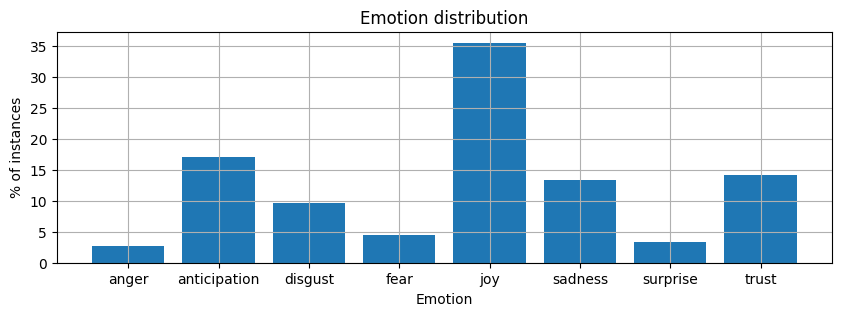

In [ ]:
%matplotlib inline

# the histogram of the data
labels = train_dataset['emotion'].unique()
post_total = len(train_dataset)
count_df = count_df.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(10,3))
plt.bar(count_df.index, count_df.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.grid(True)
plt.show()

### Decision Tree
Using decision tree and bag of word as first apporach. Set max feature as 500 to avoid the feature size to be too large. We set max depth=20, because if we don't specify it, the running time will be too long. The final accuracy in testing set is roughly 42-43%. As what I experiment, setting depth to 20 is better than 40. I guess if the tree is too deep, it may lead to overfitting. The performance will be worse.

In [10]:
from sklearn.model_selection import train_test_split

train_df, test_df= train_test_split(train_dataset, test_size=0.2, random_state=42)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk

# Using bag of words and set the max feature=500 to avoid the feature be too large
BOW_500 = CountVectorizer(max_features=500, tokenizer=nltk.word_tokenize) 
BOW_500.fit(train_df['preprocess_text'])

In [11]:
X_train = BOW_500.transform(train_df['preprocess_text'])
y_train = train_df['emotion']

X_test = BOW_500.transform(test_df['preprocess_text'])
y_test = test_df['emotion']

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [8]:
# build DecisionTree model and set max depth to 20
DT_model_1 = DecisionTreeClassifier(random_state=1, max_depth=20)

# training
DT_model_1 = DT_model_1.fit(X_train, y_train)

# predict
y_train_pred = DT_model_1.predict(X_train)
y_test_pred = DT_model_1.predict(X_test)

# Accuracy
acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)

print('\n -- Result of using Decision Tree model --')
print('Training accuracy: {}'.format(round(acc_train, 2)))
print('Testing accuracy: {}'.format(round(acc_test, 2)))

# precision, recall, f1-score
print('\n -- Classification report of using testing dataset --')
print(classification_report(y_true=y_test, y_pred=y_test_pred))

# check by confusion matrix
print('\n -- Confusion matrix of using testing dataset --')
cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred) 
print(cm)


 -- Result of using Decision Tree model --
Training accuracy: 0.42
Testing accuracy: 0.42

 -- Classification report of using testing dataset --
              precision    recall  f1-score   support

       anger       0.05      0.00      0.00      7946
anticipation       0.75      0.23      0.35     49984
     disgust       0.76      0.05      0.09     27669
        fear       0.34      0.00      0.00     12846
         joy       0.38      0.97      0.55    102943
     sadness       0.56      0.20      0.29     38745
    surprise       0.42      0.00      0.00      9816
       trust       0.70      0.03      0.05     41164

    accuracy                           0.42    291113
   macro avg       0.50      0.18      0.17    291113
weighted avg       0.54      0.42      0.31    291113


 -- Confusion matrix of using testing dataset --
[[    1    49    51     0  7329   512     0     4]
 [    3 11431    30     2 37640   793     2    83]
 [    5   183  1362     1 23984  2128     0     6]


In [15]:
# build DecisionTree model and set max depth = 40
DT_model_1 = DecisionTreeClassifier(random_state=1, max_depth=40)

# training
DT_model_1 = DT_model_1.fit(X_train, y_train)

# predict
y_train_pred = DT_model_1.predict(X_train)
y_test_pred = DT_model_1.predict(X_test)

# Accuracy
acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)

print('\n -- Result of using Decision Tree(max depth=40) model --')
print('Training accuracy: {}'.format(round(acc_train, 2)))
print('Testing accuracy: {}'.format(round(acc_test, 2)))

# precision, recall, f1-score
print('\n -- Classification report of using testing dataset --')
print(classification_report(y_true=y_test, y_pred=y_test_pred))

# check by confusion matrix
print('\n -- Confusion matrix of using testing dataset --')
cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred) 
print(cm)


 -- Result of using Decision Tree(max depth=40) model --
Training accuracy: 0.47
Testing accuracy: 0.43

 -- Classification report of using testing dataset --
              precision    recall  f1-score   support

       anger       0.12      0.00      0.01      7946
anticipation       0.68      0.29      0.40     49984
     disgust       0.54      0.08      0.13     27669
        fear       0.40      0.03      0.05     12846
         joy       0.40      0.94      0.56    102943
     sadness       0.54      0.21      0.30     38745
    surprise       0.24      0.00      0.01      9816
       trust       0.60      0.11      0.18     41164

    accuracy                           0.43    291113
   macro avg       0.44      0.21      0.20    291113
weighted avg       0.49      0.43      0.35    291113


 -- Confusion matrix of using testing dataset --
[[   23   168   175    11  6986   521     2    60]
 [   24 14274   236   143 33675   944    31   657]
 [   28   515  2114    42 22428  2380

### Naive Model

The second approach I try is using the naive model. The testing result is not really different from using the decision model. It's approximately 42%.

In [16]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

In [17]:
acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)

print('-- Result of using Naive Bayes model --')
print('Training accuracy: {}'.format(round(acc_train, 2)))
print('Testing accuracy: {}'.format(round(acc_test, 2)))
print('\n-- Classification report of testing dataset --')
print(classification_report(y_true=y_test, y_pred=y_test_pred))

print('\n -- Confusion Matrix of testing dataset --')
cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred) 
print(cm)

-- Result of using Naive Bayes model --
Training accuracy: 0.42
Testing accuracy: 0.42

-- Classification report of testing dataset --
              precision    recall  f1-score   support

       anger       0.12      0.07      0.09      7946
anticipation       0.46      0.43      0.45     49984
     disgust       0.29      0.28      0.28     27669
        fear       0.21      0.13      0.16     12846
         joy       0.47      0.67      0.55    102943
     sadness       0.38      0.32      0.35     38745
    surprise       0.25      0.07      0.11      9816
       trust       0.36      0.19      0.25     41164

    accuracy                           0.42    291113
   macro avg       0.32      0.27      0.28    291113
weighted avg       0.39      0.42      0.39    291113


 -- Confusion Matrix of testing dataset --
[[  546   694  1288   231  3567  1235    79   306]
 [  478 21738  2824  1031 17578  3277   224  2834]
 [  689  2469  7758   894  9993  4731   309   826]
 [  195  1201  14

### Deep learning model
Using deep learning model the testing result is 47%. Also, too much epochs of training will lead to overfitting.

In [19]:
from sklearn.preprocessing import LabelEncoder
import keras

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print('check label: ', label_encoder.classes_)
print('\n## Before convert')
print('y_train[0:4]:\n', y_train.iloc[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train = label_encode(label_encoder, y_train)
y_test = label_encode(label_encoder, y_test)

print('\n\n## After convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

check label:  ['anger' 'anticipation' 'disgust' 'fear' 'joy' 'sadness' 'surprise'
 'trust']

## Before convert
y_train[0:4]:
 834097        joy
355739    sadness
625638        joy
678647        joy
Name: emotion, dtype: object

y_train.shape:  (1164450,)
y_test.shape:  (291113,)


## After convert
y_train[0:4]:
 [[0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]]

y_train.shape:  (1164450, 8)
y_test.shape:  (291113, 8)


In [24]:
# Data input output
input_shape = X_train.shape[1]
output_shape = len(label_encoder.classes_)

from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import ReLU, Softmax

# input layer
model_input = Input(shape=(input_shape, )) # 500
X = model_input

# 1st hidden layer
X_W1 = Dense(units=64)(X) # 64
H1 = ReLU()(X_W1)

# 2nd hidden layer
H1_W2 = Dense(units=64)(H1) # 64
H2 = ReLU()(H1_W2)

# output layer
H2_W3 = Dense(units=output_shape)(H2) # 8
H3 = Softmax()(H2_W3)

model_output = H3

# create model
model = Model(inputs=[model_input], outputs=[model_output])

# loss function & optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# show model construction
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500)]             0         
                                                                 
 dense_3 (Dense)             (None, 64)                32064     
                                                                 
 re_lu_2 (ReLU)              (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 re_lu_3 (ReLU)              (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 8)                 520       
                                                                 
 softmax_1 (Softmax)         (None, 8)                 0   

In [25]:
from keras.callbacks import CSVLogger
import warnings
warnings.filterwarnings('ignore')

csv_logger = CSVLogger('logs/training_log.csv')

# training setting
epochs = 5
batch_size = 32

# training!
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    callbacks=[csv_logger],
                    validation_data = (X_test, y_test))
print('training finish')

Epoch 1/5
36390/36390 [==============================] - 118s 3ms/step - loss: 1.4730 - accuracy: 0.4624 - val_loss: 1.4544 - val_accuracy: 0.4667
Epoch 2/5
36390/36390 [==============================] - 138s 4ms/step - loss: 1.4379 - accuracy: 0.4752 - val_loss: 1.4426 - val_accuracy: 0.4724
Epoch 3/5
36390/36390 [==============================] - 203s 6ms/step - loss: 1.4273 - accuracy: 0.4792 - val_loss: 1.4375 - val_accuracy: 0.4746
Epoch 4/5
36390/36390 [==============================] - 40860s 1s/step - loss: 1.4214 - accuracy: 0.4811 - val_loss: 1.4366 - val_accuracy: 0.4744
Epoch 5/5
36390/36390 [==============================] - 187s 5ms/step - loss: 1.4172 - accuracy: 0.4827 - val_loss: 1.4382 - val_accuracy: 0.4749
training finish


In [26]:
# Testing result
pred_result = model.predict(X_test, batch_size=128)
pred_result = label_decode(label_encoder, pred_result)
from sklearn.metrics import accuracy_score

print('-- Result of using Deep Learning model --')
print('testing accuracy: {}'.format(round(accuracy_score(label_decode(label_encoder, y_test), pred_result), 2)))

2275/2275 [==============================] - 7s 3ms/step
-- Result of using Deep Learning model --
testing accuracy: 0.47


### Bert model
Then, I try to use BERT model to do the training, since it's still the common and popular way for dealing with NLP problem these day.
 - First, I random sample 10000 data and train it, the result is roughly 45%. Also, the prediction result for the small amount type label(anger, fear, surprise) had really bad performance.As a result, I try to do the under-sampling. The label is more balanced and the dataset size also increase. The overall test performance increase, but the submission result is not that good. I found out that maybe the data distribution in the private dataset is also unbalanced, also I should let the model have more training data to learn more information.
 - Second, I try to the two stages training for the model. In the first step, I do the under-sampling to let the model learn more about all the label. In the second step, I use all the training dataset we have to train the model(Of course, it need more training time). The final testing accuracy went to 53%.
 - Third, I also try the RoBERTa model to do the emotion classification. The RoBERTa model was proposed in RoBERTa: A Robustly Optimized BERT Pretraining Approach. It is a revised version of bert model. The final prediction result went to nearly 60%.

In [ ]:
from torch.utils.data import DataLoader,SequentialSampler,RandomSampler,TensorDataset,random_split
from transformers import BertTokenizer,BertForSequenceClassification,AdamW
from transformers import BertTokenizer

In [ ]:
LABEL_COLUMN = 'emotion'
TEXT_COLUMN = 'preprocess_text'
turn_labels = {
          'sadness':0, 
          'disgust':1, 
          'anticipation':2, 
          'joy':3, 
          'trust':4, 
          'anger':5,
          'fear':6, 
          'surprise':7
          }
num_labels = len(turn_labels.keys())

#### Under sampling

In [ ]:
# Find the minimum number of label
count_dict = train_dataset.emotion.value_counts()
min_count = min(count_dict)

In [ ]:
class_8, class_7, class_6, class_5, class_4, class_3, class_2, class_1 = train_dataset.emotion.value_counts()
c1 = train_dataset[train_dataset['emotion'] == 'joy']
c2 = train_dataset[train_dataset['emotion'] == 'anticipation']
c3 = train_dataset[train_dataset['emotion'] == 'trust']
c4 = train_dataset[train_dataset['emotion'] == 'sadness']
c5 = train_dataset[train_dataset['emotion'] == 'disgust']
c6 = train_dataset[train_dataset['emotion'] == 'fear']
c7 = train_dataset[train_dataset['emotion'] == 'surprise']
c8 = train_dataset[train_dataset['emotion'] == 'anger']
df_1 = c1.sample(min_count)
df_2 = c2.sample(min_count)
df_3 = c3.sample(min_count)
df_4 = c4.sample(min_count)
df_5 = c5.sample(min_count)
df_6 = c6.sample(min_count)
df_7 = c7.sample(min_count)
df_8 = c8.sample(min_count)

In [ ]:
from sklearn.utils import shuffle

# Concat all the data and shuffle it
train_dataset = pd.concat([df_1,df_2,df_3,df_4,df_5,df_6,df_7,df_8],axis=0)
train_dataset = shuffle(train_dataset)
train_dataset = train_dataset.reset_index(drop=True)
train_dataset

In [ ]:
input_ids = []
attention_mask = []
# Using BERT 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Using RoBERTa
# tokenizer = RobertaTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-emotion')

for i in train_dataset['preprocess_text']:
    encoded_data = tokenizer.encode_plus(
    i,
    add_special_tokens=True,
    max_length=64,
    pad_to_max_length = True,
    truncation=True,
    return_attention_mask= True,
    return_tensors='pt')
    input_ids.append(encoded_data['input_ids'])
    attention_mask.append(encoded_data['attention_mask'])
input_ids = torch.cat(input_ids,dim=0)
attention_mask = torch.cat(attention_mask,dim=0)
labels = torch.tensor([turn_labels[label] for label in train_dataset[LABEL_COLUMN]])

In [ ]:
torch.manual_seed(0)
dataset = TensorDataset(input_ids,attention_mask,labels)
train_size = int(0.9*len(dataset))
val_size = len(dataset) - train_size

train_dataset,val_dataset = random_split(dataset,[train_size,val_size])

print('Training Size - ',train_size)
print('Validation Size - ',val_size)

In [ ]:
# Build the data loader
train_dl = DataLoader(train_dataset,sampler = RandomSampler(train_dataset),
                     batch_size = 64)
val_dl = DataLoader(val_dataset,sampler = SequentialSampler(val_dataset),
                     batch_size = 64)

In [ ]:
def accuracy(preds,labels):
    pred_flat = np.argmax(preds,axis=1).flatten()
    label_flat = labels.flatten()
    print('----------------------------------------------')
    print(classification_report(y_true=label_flat, y_pred=pred_flat))
    return np.sum(pred_flat==label_flat)/len(label_flat)

In [ ]:
from sklearn.metrics import classification_report

def evaluate(model, dataloader_test, device):
    model.eval()
    loss_val_total = 0
    predictions,true_vals = [],[]
    for batch in dataloader_test:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids':batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }
        with torch.no_grad():
            outputs = model(**inputs)
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    loss_val_avg = loss_val_total / len(dataloader_test)
    predictions = np.concatenate(predictions,axis=0)
    true_vals = np.concatenate(true_vals,axis=0)
    return loss_val_avg,predictions,true_vals

In [ ]:
from torch.optim import Adam
from transformers import BertForSequenceClassification
from tqdm import tqdm
from sklearn.metrics import classification_report
import os
from transformers import get_linear_schedule_with_warmup
SAVE_MODEL_PATH = 'dataset/trained_model/model_2'

def train(model, train_data, val_data, learning_rate, epochs):

    
    use_cuda = torch.cuda.is_available()
    device = 'cuda' if use_cuda else 'cpu'
    
    optimizer = Adam(model.parameters(), lr = 2e-5, eps=1e-8)
    total_steps = len(train_data)*epochs
    scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,
                                           num_training_steps=total_steps)
    if use_cuda:
        model = model.to(device)
        print(device)
    torch.cuda.empty_cache()       
    for epoch_num in range(epochs):

        model.train()
        loss_train_total = 0
        predictions,true_train = [],[]
        for batch in tqdm(train_data):
                
            model.zero_grad()

            batch = tuple(b.to(device) for b in batch)
            inputs = {
                'input_ids':batch[0],
                'attention_mask': batch[1],
                'labels': batch[2]
            }
            outputs = model(**inputs)

            loss = outputs[0]
            logits = outputs[1]
            loss_train_total += loss.item()
            logits = logits.detach().cpu().numpy()
            label_ids = inputs['labels'].cpu().numpy()
            predictions.append(logits)
            true_train.append(label_ids)
            if len(true_train)%1000==0:
                model.save_pretrained(SAVE_MODEL_PATH)   
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()
                
        model.save_pretrained(SAVE_MODEL_PATH)
        predictions = np.concatenate(predictions,axis=0)
        true_train = np.concatenate(true_train,axis=0)
        train_acc = accuracy(predictions, true_train)
        print(f'\nEpoch {epoch_num+2}')
        print(f'Training Accuracy: {train_acc}')
        loss_train_avg = loss_train_total/len(train_dl)            
        print(f'Training loss: {loss_train_avg}')
        val_loss, predictions, true_vals = evaluate(model, val_data, device)
        val_acc = accuracy(predictions, true_vals)
        print(f'Validation Accuracy: {val_acc}')
        print(f'Validation loss: {val_loss}')

In [ ]:
# Using Bert model

EPOCHS = 1
LR = 1e-6
PRE_MODEL_PATH = 'bert-base-uncased'
model = BertForSequenceClassification.from_pretrained(
PRE_MODEL_PATH,
output_attentions = False,
output_hidden_states = False,
num_labels = num_labels)

# Using RoBERTa
# PRE_MODEL_PATH = 'roberta-base'
# model = RobertaForSequenceClassification.from_pretrained(
# PRE_MODEL_PATH,
# output_attentions = False,
# output_hidden_states = False,
# num_labels = num_labels)

# Start training
train(model, train_dl, val_dl, LR, EPOCHS)